## Import Package

In [28]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.preprocessing import OneHotEncoder, StandardScaler, KBinsDiscretizer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from imblearn.over_sampling import SMOTE
from collections import Counter
from sklearn.ensemble import RandomForestClassifier

## Gathering Data

In [2]:
X, y = make_classification(n_samples=1000, n_features=15, n_informative=10, n_redundant=2,n_clusters_per_class=1, weights=[0.9], flip_y=0, random_state=42)

# Menyusun dataset menjadi dataframe
df = pd.DataFrame(X, columns=[f"Fitur_{i}" for i in range(1, 16)])
df["Target"] = y

# Misalkan kita punya beberapa fitur kategorikal
df["Fitur_12"] = np.random.choice(["A", "B", "C"], size=1000)
df["Fitur_13"] = np.random.choice(["X", "Y", "Z"], size=1000)

df

,Fitur_1,Fitur_2,Fitur_3,Fitur_4,Fitur_5,Fitur_6,Fitur_7,Fitur_8,Fitur_9,Fitur_10,Fitur_11,Fitur_12,Fitur_13,Fitur_14,Fitur_15,Target
0,0.093303,-3.472520,-1.314199,3.525743,0.642138,2.247328,3.067502,1.146301,-2.173112,2.765828,-1.821258,B,Y,1.005559,-0.276558,0
1,-0.189574,-1.770842,-1.578851,-1.372201,-2.025230,0.518655,-0.764750,-3.958705,-0.598147,1.018789,4.194233,B,Y,-0.243630,0.285979,0
2,0.916269,-2.051770,3.631998,0.824844,1.674093,-0.436273,-0.460407,0.031633,-1.140149,2.069694,1.935251,B,Z,2.486020,-2.867291,0
3,-0.914665,-1.608657,-0.735184,-1.742743,-1.753532,0.383412,-1.057937,-2.897416,-0.830328,1.572469,5.334621,B,X,-0.788215,1.255376,0
4,-0.756784,-2.362885,-3.909120,-0.474571,-4.029843,0.947114,0.581146,-3.435229,-2.142380,2.332385,3.816539,C,X,0.712335,2.810524,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,-1.927482,-0.017325,4.884411,0.542628,3.033376,-1.904407,0.953035,1.278882,-1.293396,1.772169,-1.191263,B,X,-0.387151,-2.629004,0
996,0.347761,-1.690916,5.949207,-2.289729,2.238469,-0.067922,-0.069702,-1.436622,-2.153011,-0.867583,3.962758,C,Y,0.886822,-1.248408,0
997,1.201967,-1.263417,-1.331925,-2.468434,1.777577,2.270456,-0.431749,-1.846263,1.753033,1.858452,4.264568,A,Z,0.067260,0.931995,1
998,-2.127846,-0.975838,0.279144,0.151578,-0.443749,0.650616,-1.410265,-1.017319,-0.643070,2.142898,3.399255,B,Y,-0.128774,0.800834,0


In [6]:
# Memisahkan fitur dan target
X = df.drop(columns=["Target"], axis=1)
y = df["Target"]

# Melihat distribusi kelas pada variabel target
print("Distribusi kelas sebelum SMOTE:", Counter(y))

Distribusi kelas sebelum SMOTE: Counter({0: 901, 1: 99})


## Feature Selection

In [13]:
# ------------------- Embedded Methods -------------------

# Menggunakan Randomg Forest untuk mendapatkan fitur penting
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
X_integer = X.drop(columns=["Fitur_12", "Fitur_13"], axis=1)
rf_model.fit(X_integer, y)

# Mendapatkan fitur penting
importances = rf_model.feature_importances_
indices = np.argsort(importances)[::-1]

# Menentukan ambang batas untuk fitur penting
threshold = 0.05
important_feature_indices = [i for i in range(len(importances)) if importances[i] >= threshold]

# Menampilkan fitur penting beserta nilainya
print("Fitur yang dipilih dengan Embedded Methods (di atas ambang batas):")
for i in important_feature_indices:
    print(f"{X.columns[i]} : {importances[i]}")

# Mendapatkan nama kolom penting
important_features = X_integer.columns[important_feature_indices]

# Memindahkan fitur penting ke variabel baru
X_important = X_integer[important_features]
print("Dimensi data pelatihan dengan fitur penting:", X_important.shape)

Fitur yang dipilih dengan Embedded Methods (di atas ambang batas):
Fitur_2 : 0.11860019897866206
Fitur_3 : 0.06878603593465271
Fitur_5 : 0.07731131335837178
Fitur_8 : 0.050482655781999855
Fitur_9 : 0.2625049418105367
Fitur_10 : 0.08958259568334655
Fitur_11 : 0.06365230544114515
Fitur_13 : 0.12578161860669113
Dimensi data pelatihan dengan fitur penting: (1000, 8)


In [15]:
# Menggabungkan fitur numerik dan kategorikal
X_selected = pd.concat([X_important, X["Fitur_12"]], axis=1)
X_selected = pd.concat([X_selected, X["Fitur_13"]], axis=1)
X_selected

,Fitur_2,Fitur_3,Fitur_5,Fitur_8,Fitur_9,Fitur_10,Fitur_11,Fitur_15,Fitur_12,Fitur_13
0,-3.472520,-1.314199,0.642138,1.146301,-2.173112,2.765828,-1.821258,-0.276558,B,Y
1,-1.770842,-1.578851,-2.025230,-3.958705,-0.598147,1.018789,4.194233,0.285979,B,Y
2,-2.051770,3.631998,1.674093,0.031633,-1.140149,2.069694,1.935251,-2.867291,B,Z
3,-1.608657,-0.735184,-1.753532,-2.897416,-0.830328,1.572469,5.334621,1.255376,B,X
4,-2.362885,-3.909120,-4.029843,-3.435229,-2.142380,2.332385,3.816539,2.810524,C,X
...,...,...,...,...,...,...,...,...,...,...
995,-0.017325,4.884411,3.033376,1.278882,-1.293396,1.772169,-1.191263,-2.629004,B,X
996,-1.690916,5.949207,2.238469,-1.436622,-2.153011,-0.867583,3.962758,-1.248408,C,Y
997,-1.263417,-1.331925,1.777577,-1.846263,1.753033,1.858452,4.264568,0.931995,A,Z
998,-0.975838,0.279144,-0.443749,-1.017319,-0.643070,2.142898,3.399255,0.800834,B,Y


## Encoding

In [16]:
# Encoding fitur kategorikal menjadi numerik menggunakan Label Encoding
from sklearn.preprocessing import LabelEncoder

label_encoder = LabelEncoder()

# Melakukan encoding terhadap fitur_12
X_selected["Fitur_12"] = label_encoder.fit_transform(X_selected["Fitur_12"])

# Melakukan encoding terhadap fitur 13
X_selected["Fitur_13"] = label_encoder.fit_transform(X_selected["Fitur_13"])

X_selected

,Fitur_2,Fitur_3,Fitur_5,Fitur_8,Fitur_9,Fitur_10,Fitur_11,Fitur_15,Fitur_12,Fitur_13
0,-3.472520,-1.314199,0.642138,1.146301,-2.173112,2.765828,-1.821258,-0.276558,1,1
1,-1.770842,-1.578851,-2.025230,-3.958705,-0.598147,1.018789,4.194233,0.285979,1,1
2,-2.051770,3.631998,1.674093,0.031633,-1.140149,2.069694,1.935251,-2.867291,1,2
3,-1.608657,-0.735184,-1.753532,-2.897416,-0.830328,1.572469,5.334621,1.255376,1,0
4,-2.362885,-3.909120,-4.029843,-3.435229,-2.142380,2.332385,3.816539,2.810524,2,0
...,...,...,...,...,...,...,...,...,...,...
995,-0.017325,4.884411,3.033376,1.278882,-1.293396,1.772169,-1.191263,-2.629004,1,0
996,-1.690916,5.949207,2.238469,-1.436622,-2.153011,-0.867583,3.962758,-1.248408,2,1
997,-1.263417,-1.331925,1.777577,-1.846263,1.753033,1.858452,4.264568,0.931995,0,2
998,-0.975838,0.279144,-0.443749,-1.017319,-0.643070,2.142898,3.399255,0.800834,1,1


# Checking & Cleaning Outlier

In [44]:
# Memilih kolom numerik tanpa fitur 12 dan 13
numeric_columns = X_selected.select_dtypes(include=["int64", "float64"]).columns
numeric_columns = numeric_columns.drop(["Fitur_12", "Fitur_13"])

# Sehingga dapat diperoleh X_important.columns = numeric columns

# Membuat salinan data dari X_important (data asli) sebagai perbandingan
X_cleaned = X_important.copy()
numeric_columns

Index(['Fitur_2', 'Fitur_3', 'Fitur_5', 'Fitur_8', 'Fitur_9', 'Fitur_10',
       'Fitur_11', 'Fitur_15'],
      dtype='object')

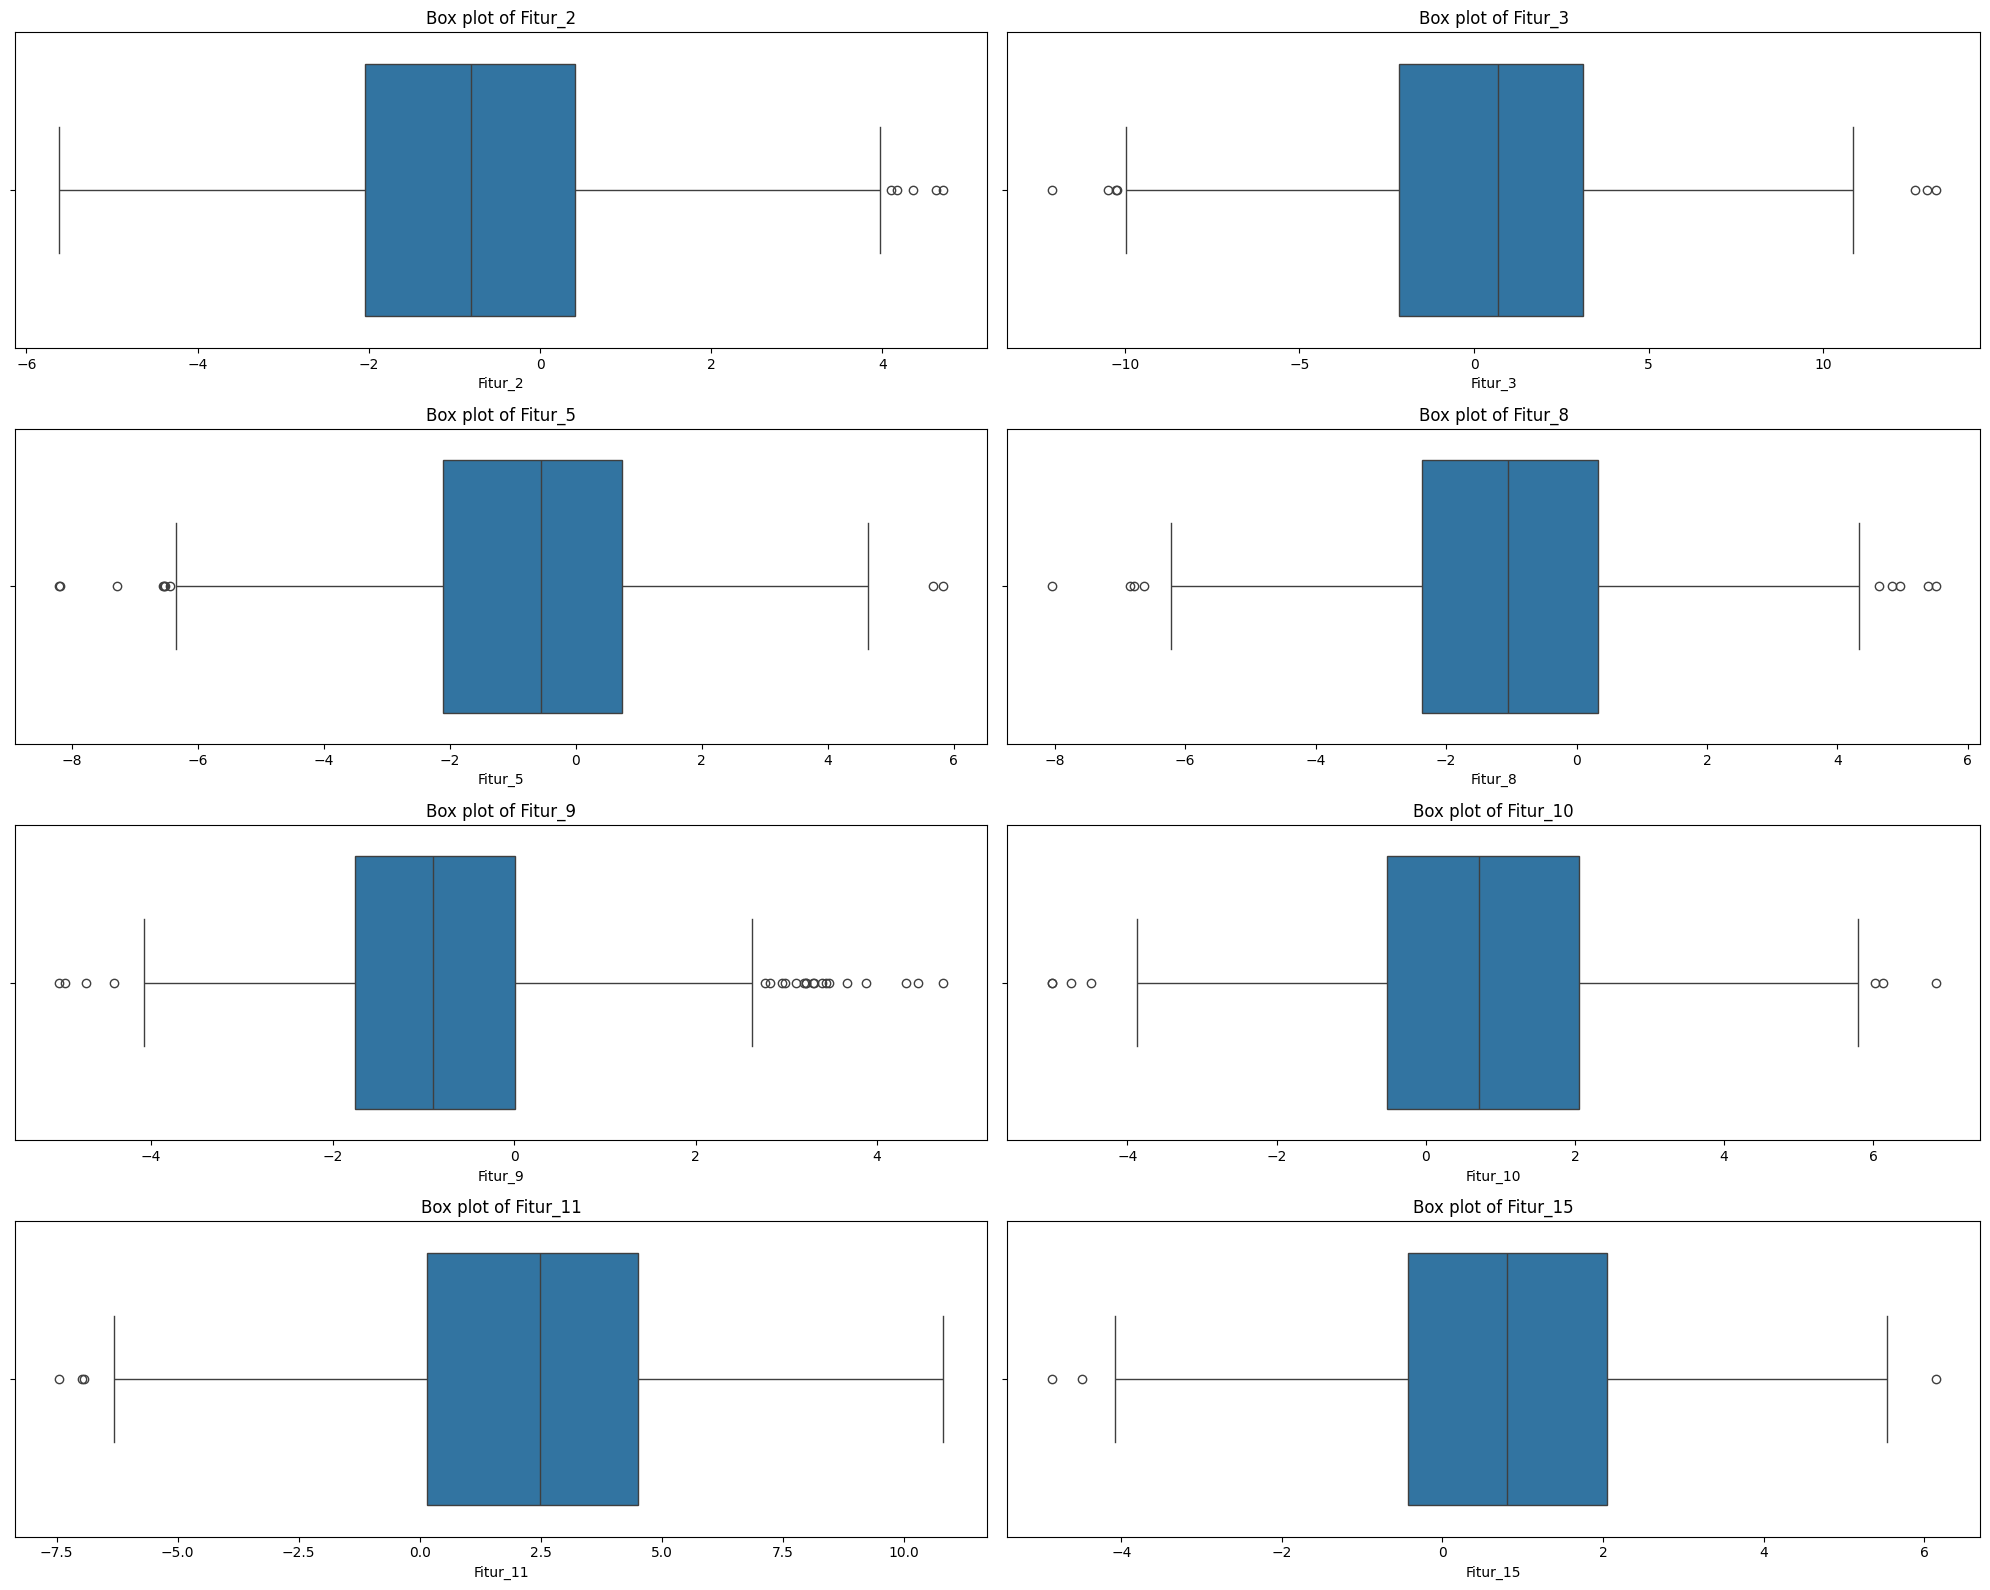

In [46]:
# ------------------- Outlier Checking -------------------
num_vars = X_important.shape[1]

n_cols = 2
n_rows = -(-num_vars // n_cols)

fig, axes = plt.subplots(n_rows, n_cols, figsize=(20, n_rows*4))
axes = axes.flatten()

for i, column in enumerate(X_important.columns):
    sns.boxplot(x=X_important[column], ax=axes[i])
    axes[i].set_title(f"Box plot of {column}")
plt.tight_layout()
    


In [61]:
# ------------------- Outlier Cleaning -------------------

# Melihat outlier dengan IQR
for col in numeric_columns:
    Q1 = X_important[col].quantile(0.25)
    Q3 = X_important[col].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5*IQR
    upper_bound = Q3 + 1.5*IQR
    
    # Identifikasi Outlier
    outliers = X_cleaned[(X_cleaned[col] < lower_bound) | (X_cleaned[col] > upper_bound)]

    # Hapus data outlier
    X_cleaned = X_cleaned.drop(outliers.index)

print(X_cleaned.shape)
print(y.shape)



(944, 8)
(1000,)


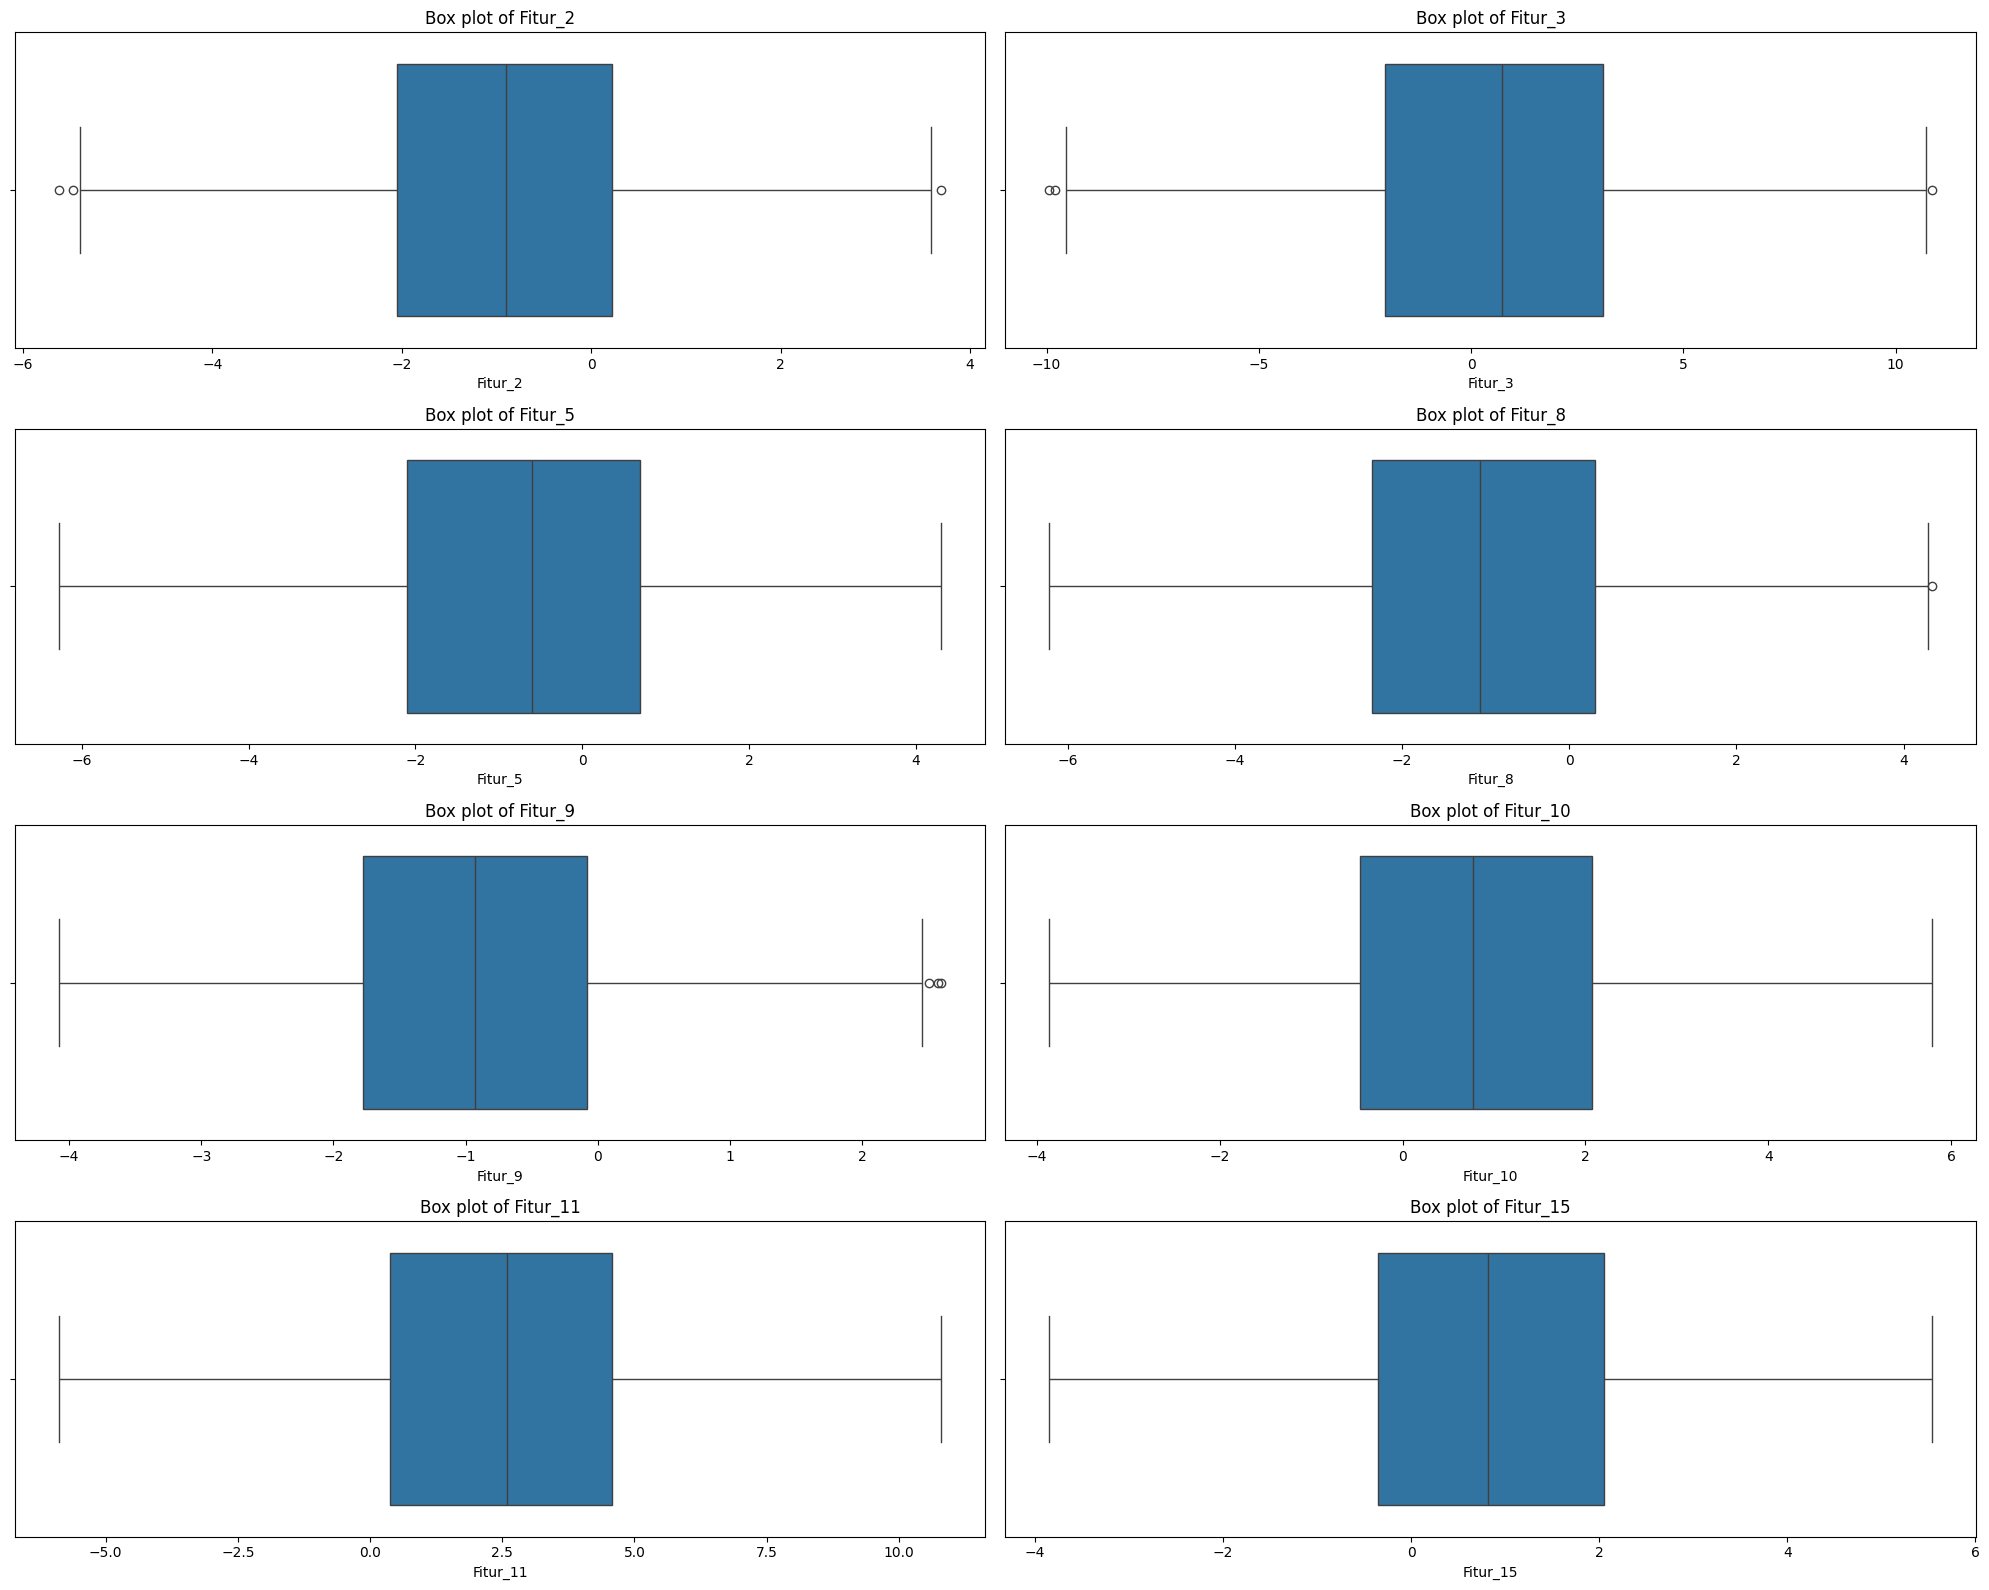

In [47]:
# ------------------- After Outlier Cleaning -------------------

num_vars = X_cleaned.shape[1]

n_cols = 2
n_rows = -(-num_vars // n_cols)

fig, axes = plt.subplots(n_rows, n_cols, figsize=(20, n_rows*4))
axes = axes.flatten()

for i, column in enumerate(X_cleaned.columns):
    sns.boxplot(x=X_cleaned[column], ax=axes[i])
    axes[i].set_title(f"Box plot of {column}")
plt.tight_layout()
    

In [53]:
X_cleaned

,Fitur_2,Fitur_3,Fitur_5,Fitur_8,Fitur_9,Fitur_10,Fitur_11,Fitur_15
0,-3.472520,-1.314199,0.642138,1.146301,-2.173112,2.765828,-1.821258,-0.276558
1,-1.770842,-1.578851,-2.025230,-3.958705,-0.598147,1.018789,4.194233,0.285979
2,-2.051770,3.631998,1.674093,0.031633,-1.140149,2.069694,1.935251,-2.867291
3,-1.608657,-0.735184,-1.753532,-2.897416,-0.830328,1.572469,5.334621,1.255376
4,-2.362885,-3.909120,-4.029843,-3.435229,-2.142380,2.332385,3.816539,2.810524
...,...,...,...,...,...,...,...,...
994,-2.041914,-0.803401,-0.697435,2.116836,-1.075422,2.308076,-0.972784,0.056426
995,-0.017325,4.884411,3.033376,1.278882,-1.293396,1.772169,-1.191263,-2.629004
996,-1.690916,5.949207,2.238469,-1.436622,-2.153011,-0.867583,3.962758,-1.248408
997,-1.263417,-1.331925,1.777577,-1.846263,1.753033,1.858452,4.264568,0.931995


## Oversampling

In [49]:
# ------------------- After Outlier Cleaning -------------------

# Inisialisasi SMOTE
smote = SMOTE(random_state=42)

# Melakukan oversampling pada dataset
X_resampled, y_resampled = smote.fit_resample(X_cleaned, y)

# Menampilkan disribusi kelas setelah SMOTE
print("Distribusi kelas setelah SMOTE:", Counter(y_resampled))

ValueError: Found input variables with inconsistent numbers of samples: [944, 1000]